In [4]:
import pandas as pd
import numpy as np
import os
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import random
import tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers,mixed_precision
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

In [47]:
from google.colab import drive
drive.mount('/content/drive')

bird_classes = pd.read_excel('/content/drive/My Drive/Colab Notebooks/Data/Classes.xlsx')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
bird_classes.columns = ['folder','class']
inx_name = {}
name_inx = {}
n = 0
for b in bird_classes['folder']:
    inx_name[n] = b
    name_inx[b] = n
    n+=1

In [48]:
IMAGE_SIZE=(224,224)
path = '/content/drive/My Drive/Colab Notebooks/Data/images'
data_all=tf.keras.preprocessing.image_dataset_from_directory(
    path,
    label_mode='categorical',
    image_size=IMAGE_SIZE
)

Found 1176 files belonging to 20 classes.


In [49]:
import splitfolders

#### input dataset that want to split
input_path = '/content/drive/My Drive/Colab Notebooks/Data/images/'  

output_folder= '/content/drive/My Drive/Colab Notebooks/Data'

splitfolders.ratio(input = input_path, output= output_folder, seed=1337, ratio = (0.7, 0.15, 0.15))

Copying files: 1176 files [03:24,  5.74 files/s]


In [14]:
#VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
IMAGE_SIZE=(224,224)
new_path = '/content/drive/My Drive/Colab Notebooks/Data/'
train_idg = ImageDataGenerator(preprocessing_function = preprocess_input, rotation_range=20, horizontal_flip=True)
train_ds = train_idg.flow_from_directory(
directory = new_path+"train",
target_size = IMAGE_SIZE,
class_mode='categorical',
shuffle = True,batch_size= 5 )
#test
test_idg = ImageDataGenerator(preprocessing_function = preprocess_input, rotation_range=20, horizontal_flip=True)
test_ds = test_idg.flow_from_directory(
directory = new_path+"test",
target_size = IMAGE_SIZE,
class_mode='categorical',
shuffle = False,batch_size= 5)
#val
val_idg = ImageDataGenerator(preprocessing_function = preprocess_input, rotation_range=20, horizontal_flip=True)
val_ds = val_idg.flow_from_directory(
directory = new_path+"val",
target_size = IMAGE_SIZE,
class_mode='categorical',
shuffle = False,batch_size= 5 )

Found 820 images belonging to 20 classes.
Found 185 images belonging to 20 classes.
Found 171 images belonging to 20 classes.


In [126]:
#adding layers
model_VGG = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
model_VGG.trainable = False
layer0 = tf.keras.layers.Flatten(name='flatten')(model_VGG.output)
norm = layers.BatchNormalization()(layer0)
layer1 = tf.keras.layers.Dense(1028, activation='relu')(norm)
dropout = layers.Dropout(rate=0.2)(layer1)
lastlayer = tf.keras.layers.Dense(20, activation='softmax')(dropout)

In [127]:
new_model = tf.keras.Model(inputs=model_VGG.input, outputs=lastlayer)
new_model.compile(
    optimizer=Adam(0.00005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
 
# print the new_model summary
new_model.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [128]:
from tensorflow.keras.callbacks import EarlyStopping
callbacks = [EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)]
history_VGG = new_model.fit(train_ds,epochs=50,validation_data=val_ds,callbacks=callbacks)

Epoch 1/50
164/164 [==============================] - 18s 105ms/step - loss: 2.2422 - accuracy: 0.3280 - val_loss: 1.4619 - val_accuracy: 0.5614
Epoch 2/50
164/164 [==============================] - 17s 104ms/step - loss: 0.8309 - accuracy: 0.7671 - val_loss: 1.2235 - val_accuracy: 0.6257
Epoch 3/50
164/164 [==============================] - 17s 106ms/step - loss: 0.5004 - accuracy: 0.8732 - val_loss: 1.2064 - val_accuracy: 0.6433
Epoch 4/50
164/164 [==============================] - 17s 104ms/step - loss: 0.4109 - accuracy: 0.8951 - val_loss: 1.2732 - val_accuracy: 0.6433
Epoch 5/50
164/164 [==============================] - 18s 110ms/step - loss: 0.2433 - accuracy: 0.9439 - val_loss: 1.0368 - val_accuracy: 0.6959
Epoch 6/50
164/164 [==============================] - 17s 102ms/step - loss: 0.1724 - accuracy: 0.9671 - val_loss: 1.2030 - val_accuracy: 0.6550
Epoch 7/50
164/164 [==============================] - 17s 102ms/step - loss: 0.1516 - accuracy: 0.9610 - val_loss: 1.0695 - val_ac

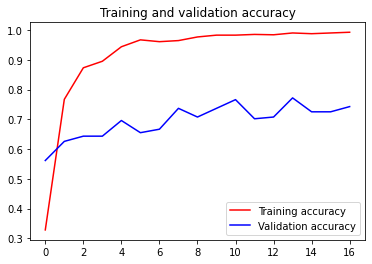

<Figure size 432x288 with 0 Axes>

In [134]:
#print result
acc = history_VGG.history['accuracy']
val_acc = history_VGG.history['val_accuracy']
loss = history_VGG.history['loss']
val_loss = history_VGG.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

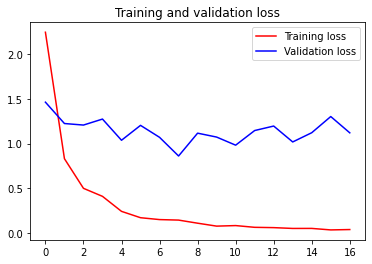

<Figure size 432x288 with 0 Axes>

In [135]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [139]:
from sklearn.metrics import classification_report
test_d = test_ds.classes
Y_pred = np.argmax(new_model.predict(test_ds),axis=1)
print('Confusion Matrix')
print(classification_report(test_d,Y_pred,target_names=bird_classes['folder']))

37/37 [==============================] - 3s 87ms/step
Confusion Matrix
                               precision    recall  f1-score   support

           005.Crested_Auklet       0.71      0.62      0.67         8
                 013.Bobolink       0.86      0.67      0.75         9
           015.Lazuli_Bunting       1.00      0.80      0.89        10
         023.Brandt_Cormorant       1.00      0.60      0.75        10
   040.Olive_sided_Flycatcher       0.50      0.56      0.53         9
041.Scissor_tailed_Flycatcher       0.89      0.89      0.89         9
         067.Anna_Hummingbird       0.89      0.89      0.89         9
          072.Pomarine_Jaeger       1.00      0.78      0.88         9
          076.Dark_eyed_Junco       0.75      0.67      0.71         9
          081.Pied_Kingfisher       0.73      0.89      0.80         9
        082.Ringed_Kingfisher       0.67      0.89      0.76         9
             086.Pacific_Loon       0.75      1.00      0.86         9
     

In [67]:
#EfficientNetB0
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
directory = new_path+"train",
image_size = IMAGE_SIZE,
label_mode='categorical',
shuffle = True,batch_size= 5 )
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
directory = new_path+"test",
image_size = IMAGE_SIZE,
label_mode='categorical',
shuffle = False,batch_size= 5 )
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
directory = new_path+"val",
image_size = IMAGE_SIZE,
label_mode='categorical',
shuffle = False,batch_size= 5 )

train_data=train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_data=val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_data=test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

Found 820 files belonging to 20 classes.
Found 185 files belonging to 20 classes.
Found 171 files belonging to 20 classes.


In [68]:
data_augmentation=keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2,fill_mode='nearest'),
    # layers.Rescaling(scale=1.0/255)
],name='Data_Augmentation_Layer')

In [70]:
inputs=layers.Input(shape=(224,224,3),name='input_layer')
base_model=keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False
x=data_augmentation(inputs)
x=base_model(x,training=False)
x=layers.GlobalAveragePooling2D(name='Global_Average_Pool_2D')(x)
norm = layers.BatchNormalization()(x)
layer1 = tf.keras.layers.Dense(1280, activation='relu')(norm)
dropout = layers.Dropout(rate=0.2)(layer1)
outputs=layers.Dense(20,activation='softmax',dtype=tf.float32,name="Output_layer")(dropout)

model=keras.Model(inputs,outputs,name="model")
model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)
history_ENB = model.fit(train_data,epochs=50,validation_data=val_data,callbacks=callbacks)

Epoch 1/50
164/164 [==============================] - 80s 445ms/step - loss: 1.7264 - accuracy: 0.6232 - val_loss: 0.6451 - val_accuracy: 0.8187
Epoch 2/50
164/164 [==============================] - 69s 420ms/step - loss: 1.1556 - accuracy: 0.7402 - val_loss: 1.3318 - val_accuracy: 0.7895
Epoch 3/50
164/164 [==============================] - 71s 429ms/step - loss: 0.7597 - accuracy: 0.8512 - val_loss: 1.3202 - val_accuracy: 0.8187
Epoch 4/50
164/164 [==============================] - 69s 421ms/step - loss: 0.8572 - accuracy: 0.8415 - val_loss: 1.2329 - val_accuracy: 0.8538
Epoch 5/50
164/164 [==============================] - 69s 422ms/step - loss: 0.5932 - accuracy: 0.8780 - val_loss: 1.5303 - val_accuracy: 0.8363
Epoch 6/50
164/164 [==============================] - 69s 421ms/step - loss: 0.7537 - accuracy: 0.8744 - val_loss: 1.7935 - val_accuracy: 0.8012
Epoch 7/50
164/164 [==============================] - 71s 432ms/step - loss: 0.6796 - accuracy: 0.8927 - val_loss: 1.9064 - val_ac

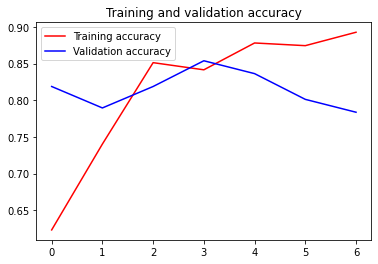

<Figure size 432x288 with 0 Axes>

In [72]:
#print result
acc = history_ENB.history['accuracy']
val_acc = history_ENB.history['val_accuracy']
loss = history_ENB.history['loss']
val_loss = history_ENB.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

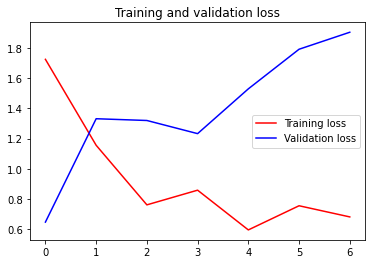

<Figure size 432x288 with 0 Axes>

In [73]:
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [71]:
from sklearn.metrics import classification_report
test_d = test_ds.unbatch()
test_labels = list(test_d.map(lambda x, y: y))
y_test_arg=np.argmax(test_labels,axis=1)
Y_pred = np.argmax(model.predict(test_ds),axis=1)
print('Confusion Matrix')
print(classification_report(y_test_arg,Y_pred,target_names=bird_classes['folder']))

37/37 [==============================] - 13s 317ms/step
Confusion Matrix
                               precision    recall  f1-score   support

           005.Crested_Auklet       1.00      0.75      0.86         8
                 013.Bobolink       1.00      1.00      1.00         9
           015.Lazuli_Bunting       1.00      0.80      0.89        10
         023.Brandt_Cormorant       0.71      1.00      0.83        10
   040.Olive_sided_Flycatcher       1.00      0.67      0.80         9
041.Scissor_tailed_Flycatcher       0.73      0.89      0.80         9
         067.Anna_Hummingbird       1.00      1.00      1.00         9
          072.Pomarine_Jaeger       0.90      1.00      0.95         9
          076.Dark_eyed_Junco       0.89      0.89      0.89         9
          081.Pied_Kingfisher       1.00      0.78      0.88         9
        082.Ringed_Kingfisher       0.90      1.00      0.95         9
             086.Pacific_Loon       1.00      0.89      0.94         9
   